In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

sns.set()
sns.set_style("ticks")
sns.set_context("paper", font_scale = 1.5)
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 20

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import Tensor
from torch.nn import functional as F
from torch.nn import init
from torch.nn import Module
import FrEIA.framework as Ff
import FrEIA.modules as Fm
from sklearn.model_selection import train_test_split

#print('Python', sys.version)

In [4]:
class dalitz_dataset(Dataset):
    """
    Creates Dalitz dataset so that it can be used by the pythorch syntax.
    """

    def __init__(self, data):
        self.data = data

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        sample = self.data[idx]
        return sample

In [5]:
def subnet_fc(dims_in, dims_out):
    return nn.Sequential(nn.Linear(dims_in, 100), 
                         nn.SiLU(), # nn.ReLU(),
                         nn.Linear(100, 100),
                         nn.SiLU(), # nn.ReLU(),
                         nn.Linear(100, 100),
                         nn.SiLU(), # nn.ReLU(),
                         nn.Linear(100, 100),
                         nn.SiLU(), # nn.ReLU(),
                         nn.Linear(100, 100),
                         nn.SiLU(), # nn.ReLU(),
                         nn.Linear(100, 100),
                         nn.SiLU(), # nn.ReLU(),
                         nn.Linear(100, 100),
                         nn.SiLU(), # nn.ReLU(),
                         nn.Linear(100, 100),
                         nn.SiLU(), # nn.ReLU(),
                         nn.Linear(100, 100),
                         nn.SiLU(), # nn.ReLU(),
                         nn.Linear(100,  dims_out))

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [7]:
def gmm2d_log_prob_corr(z, mu, sigma, rho, logits=None):
    """
    Log-probability of a 2D Gaussian mixture with per-component correlation.

    z      : (B,2) batch of points
    mu     : (K,2) component means
    sigma  : (K,2) component stds (positive)
    rho    : (K,) correlations in (-1,1) or scalar
    logits : (K,) unnormalized mixture weights, or None for uniform

    returns: (B,) log p(z)
    """
    B, K = z.shape[0], mu.shape[0]
    z    = z[:, None, :]                         # (B,1,2)
    mu   = mu[None, :, :]                        # (1,K,2)
    sig  = sigma[None, :, :]                     # (1,K,2)

    # correlations (vectorize scalar if given)
    if not isinstance(rho, torch.Tensor):
        rho = torch.as_tensor(rho, device = z.device, dtype = z.dtype)
    if rho.ndim == 0:
        rho = rho.repeat(K)
    one_m_r2 = 1.0 - rho * rho                   # (K,)
    assert torch.all(one_m_r2 > 0), "gmm2d_log_prob_corr: require |rho|<1 per component."

    # standardized deviations and quadratic form
    x1 = (z[..., 0] - mu[..., 0]) / sig[..., 0]  # (B,K)
    x2 = (z[..., 1] - mu[..., 1]) / sig[..., 1]  # (B,K)
    quad = (x1 * x1 + x2 * x2 - 2.0 * rho[None, :] * x1 * x2) / one_m_r2[None, :]  # (B,K)

    # per-component log-density (without mixture weights)
    log_norm = (np.log(2.0 * np.pi)
                + torch.log(sigma[:, 0]) + torch.log(sigma[:, 1])
                + 0.5 * torch.log(one_m_r2))       # (K,)
    log_comp = -(log_norm[None, :] + 0.5 * quad)   # (B,K)

    # mixture weights
    if logits is None:
        logw = torch.full((K,), - np.log(K), device = z.device, dtype = z.dtype)
    else:
        logw = torch.log_softmax(logits, dim = 0)

    return torch.logsumexp(log_comp + logw[None, :], dim=1)  # (B,)

In [8]:
@torch.no_grad()
def gmm2d_sample(n, mu, sigma, rho, logits=None):
    """
    Sample from a 2D Gaussian Mixture with per-component correlation.

    n      : int          number of samples
    mu     : (K,2)        component means
    sigma  : (K,2)        component stds (positive)
    rho    : (K,) or ()   correlations in (-1,1)
    logits : (K,) or None mixture logits; None => uniform

    returns: (n,2) samples
    """
    K, device, dtype = mu.shape[0], mu.device, mu.dtype

    # convert logits into mixture probabilities
    if logits is None:
        probs = torch.full((K,), 1.0 / K, device=device, dtype=dtype)
    else:
        probs = torch.softmax(logits.to(device=device, dtype=dtype), dim=0)

    # choose component index for each sample
    k = torch.distributions.Categorical(probs=probs).sample((n,))     # (n,)

    # gather parameters for chosen components
    mu_k, s1, s2 = mu[k], sigma[k, 0], sigma[k, 1]                    # (n,2),(n,),(n,)

    # pick correlations for chosen components
    rho_all = rho if isinstance(rho, torch.Tensor) else torch.as_tensor(rho, device=device, dtype=dtype)
    if rho_all.ndim == 0: rho_all = rho_all.expand(K)                 # broadcast scalar to (K,)
    rho_k = rho_all.to(device=device, dtype=dtype)[k]                 # (n,)

    # draw iid standard normals
    eps = torch.randn(n, 2, device=device, dtype=dtype)
    z1, z2 = eps[:, 0], eps[:, 1]

    # reparameterization for correlated bivariate normals
    x1 = mu_k[:, 0] + s1 * z1
    x2 = mu_k[:, 1] + s2 * (rho_k * z1 + torch.sqrt(1.0 - rho_k * rho_k) * z2)

    return torch.stack([x1, x2], dim=1)

In [9]:
class GMM2dBase(nn.Module):
    """
    Trainable 2D Gaussian Mixture base on [0,1]^2.
    Parameters are raw; constraints enforced by projection after optimizer.step().
    """
    def __init__(self, K):
        super().__init__()
        self.K = K
        self.logits = nn.Parameter(torch.zeros(K))          
        self.mu     = nn.Parameter(torch.rand(K, 2))    
        self.sigma  = nn.Parameter(torch.full((K, 2), 0.20))    
        self.rho    = nn.Parameter(torch.zeros(K))              

    def log_prob(self, z):
        # Use raw params; they are kept valid by project_params_() after each step.
        return gmm2d_log_prob_corr(z, self.mu, self.sigma, self.rho, self.logits)

    @torch.no_grad()
    def sample(self, n):
        return gmm2d_sample(n, self.mu, self.sigma, self.rho, self.logits)

    @torch.no_grad()
    def project_params_(self):
        """
        Projection to maintain constraints without touching valid interior values:
          mu in [0,1]^2      (box projection)
          sigma >= eps       (positivity; choose eps small)
          rho in (-1+eps, 1-eps)
        """
        eps = 1e-6
        # Simply clip the gmm means without redistributing
        #self.mu.clamp_(0.0, 1.0)

        # Find components out of bounds and reinitialize those entries uniformly in [0,1]
        mask = (self.mu < 0.0) | (self.mu > 1.0)
        self.mu.data[mask] = torch.rand_like(self.mu.data[mask])

        # Sigma with no upper bound
        self.sigma.clamp_(eps) 
        self.rho.clamp_(-1.0 + 1e-6, 1.0 - 1e-6)


In [10]:
def inn_loss(z, log_jac_det, base):
    """
    Negative log-likelihood for INN with trainable GMM base.

    z           : (B,2) latent variables
    log_jac_det : (B,)  log|det ∂z/∂x|
    base        : GMM2dBase (has .log_prob)

    returns     : scalar loss
    """
    log_pz = base.log_prob(z)
    return (-(log_pz + log_jac_det)).mean() / z.shape[1]

In [11]:
def train(epochs, dataloader, inn, base, optimizer, freeze_epoch, scheduler=None):
    """
    One training epoch for INN + GMM base.

    dataloader : DataLoader of inputs x
    inn        : invertible network
    base       : GMM2dBase instance
    optimizer  : optimizer over inn + base params
    freeze_epoch : int  freeze base after this many epochs are completed (1-based)
    scheduler  : optional LR scheduler (recreate or disable after freeze if needed)
    """
    base_frozen = False

    for epoch in tqdm(range(epochs), ncols=100):
        inn.train(); base.train()
        current_lr = optimizer.param_groups[0]['lr']

        for i, X in enumerate(dataloader):
            z, log_jac = inn(X)
            loss = inn_loss(z, log_jac, base)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Enforce constraints only while base is trainable
            if not base_frozen:
                base.project_params_()

            if scheduler is not None:
                scheduler.step(loss)
                
            if i % 100 == 0:
                print(f'INN loss: {loss.item():.6f}, lr: {current_lr:.2e}')

        # Freeze base after completing `freeze_epoch` epochs
        if (epoch + 1 == freeze_epoch) and not base_frozen:
            for p in base.parameters():
                p.requires_grad = False
            base_frozen = True

            # Rebuild optimizer to exclude base params
            optimizer = torch.optim.Adam(inn.parameters(), lr=current_lr)

            # Turn off the scheduler
            if scheduler is not None:
                scheduler = None


In [ ]:
# Load in Dalitz dataset
mp_thetap = np.load('D_Kspipi_SDP_1e7.npy')

# Split data into train, validation
mp_thetap_train, mp_thetap_val = train_test_split(mp_thetap, test_size=0.8)

print("Training set size: ", mp_thetap_train.shape, "Validation set size: ", mp_thetap_val.shape)

# Convert into torch objects
mp_thetap_train = torch.Tensor(mp_thetap_train)
#mp_thetap_val   = torch.Tensor(mp_thetap_val)

trainset = dalitz_dataset(mp_thetap_train)
#valset   = dalitz_dataset(mp_thetap_val)

batch_size = 50000

train_dataloader = DataLoader(trainset, batch_size = batch_size, shuffle = True)
#val_dataloader = DataLoader(valset, batch_size = batch_size, shuffle = True)

# Initialize hyperparameters
epochs = 25
freeze_epoch = 50
learning_rate = 0.001
min_learning_rate = 1e-6

n_dim = mp_thetap.shape[1]
n_blocks = 10
training_size = len(mp_thetap)

# Define the model
inn = Ff.SequenceINN(n_dim)
for k in range(n_blocks):
    inn.append(Fm.AllInOneBlock, subnet_constructor=subnet_fc, permute_soft=True)

print("Model Architecture: ")
print(inn)

# Initialize the GMM base
K = 50
base = GMM2dBase(K)
base_mu_init = base.mu.clone().detach()

#print("Initial GMM means: \n", base_mu_init)

# Combine flow + base GMM parameters
params = list(inn.parameters()) + list(base.parameters())

# Initialize optimizer
optimizer = torch.optim.Adam(params, lr=learning_rate)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode= 'min', factor = 0.9, patience = 150, min_lr = min_learning_rate)
#scheduler = None

# Train
#for t in tqdm(range(epochs), ncols = 100):
#    train(train_dataloader, inn, base, optimizer, scheduler)
train(epochs, train_dataloader, inn, base, optimizer, freeze_epoch, scheduler)

print("Done!")

Training set size:  (2000000, 2) Validation set size:  (8000000, 2)
Model Architecture: 
SequenceINN(
  (module_list): ModuleList(
    (0-9): 10 x AllInOneBlock(
      (softplus): Softplus(beta=0.5, threshold=20.0)
      (subnet): Sequential(
        (0): Linear(in_features=1, out_features=100, bias=True)
        (1): SiLU()
        (2): Linear(in_features=100, out_features=100, bias=True)
        (3): SiLU()
        (4): Linear(in_features=100, out_features=100, bias=True)
        (5): SiLU()
        (6): Linear(in_features=100, out_features=100, bias=True)
        (7): SiLU()
        (8): Linear(in_features=100, out_features=100, bias=True)
        (9): SiLU()
        (10): Linear(in_features=100, out_features=100, bias=True)
        (11): SiLU()
        (12): Linear(in_features=100, out_features=100, bias=True)
        (13): SiLU()
        (14): Linear(in_features=100, out_features=100, bias=True)
        (15): SiLU()
        (16): Linear(in_features=100, out_features=100, bias=True

  0%|                                                                        | 0/50 [00:00<?, ?it/s]

INN loss: 1.783897, lr: 1.00e-03


  2%|█▏                                                           | 1/50 [02:30<2:02:38, 150.16s/it]

INN loss: -0.275698, lr: 1.00e-03


  4%|██▍                                                          | 2/50 [04:48<1:54:37, 143.27s/it]

INN loss: -0.447843, lr: 1.00e-03


  6%|███▋                                                         | 3/50 [07:07<1:50:32, 141.12s/it]

INN loss: -0.468122, lr: 1.00e-03


  8%|████▉                                                        | 4/50 [09:27<1:47:50, 140.66s/it]

INN loss: -0.486125, lr: 1.00e-03


 10%|██████                                                       | 5/50 [11:48<1:45:48, 141.07s/it]

INN loss: -0.517097, lr: 1.00e-03


 12%|███████▎                                                     | 6/50 [14:20<1:45:58, 144.51s/it]

INN loss: -0.529333, lr: 1.00e-03


 14%|████████▌                                                    | 7/50 [16:55<1:46:00, 147.93s/it]

INN loss: -0.537432, lr: 1.00e-03


 16%|█████████▊                                                   | 8/50 [19:55<1:50:41, 158.14s/it]

INN loss: -0.533738, lr: 1.00e-03


 18%|██████████▉                                                  | 9/50 [22:26<1:46:43, 156.19s/it]

INN loss: -0.542725, lr: 1.00e-03


 20%|████████████                                                | 10/50 [24:59<1:43:18, 154.96s/it]

INN loss: -0.548578, lr: 1.00e-03


 22%|█████████████▏                                              | 11/50 [27:14<1:36:54, 149.10s/it]

INN loss: -0.550035, lr: 1.00e-03


 24%|██████████████▍                                             | 12/50 [29:45<1:34:43, 149.56s/it]

INN loss: -0.547284, lr: 1.00e-03


 26%|███████████████▌                                            | 13/50 [32:14<1:32:01, 149.23s/it]

INN loss: -0.552658, lr: 1.00e-03


 28%|████████████████▊                                           | 14/50 [34:35<1:28:03, 146.77s/it]

INN loss: -0.556877, lr: 1.00e-03


 30%|██████████████████                                          | 15/50 [36:55<1:24:31, 144.90s/it]

INN loss: -0.549530, lr: 1.00e-03


 32%|███████████████████▏                                        | 16/50 [39:20<1:22:06, 144.90s/it]

INN loss: -0.549214, lr: 1.00e-03


 34%|████████████████████▍                                       | 17/50 [41:45<1:19:39, 144.83s/it]

INN loss: -0.555013, lr: 9.00e-04


 36%|█████████████████████▌                                      | 18/50 [44:13<1:17:45, 145.80s/it]

INN loss: -0.554914, lr: 9.00e-04


 38%|██████████████████████▊                                     | 19/50 [46:45<1:16:21, 147.78s/it]

INN loss: -0.549601, lr: 8.10e-04


 40%|████████████████████████                                    | 20/50 [49:08<1:13:10, 146.36s/it]

INN loss: -0.550956, lr: 8.10e-04


 42%|█████████████████████████▏                                  | 21/50 [51:34<1:10:37, 146.13s/it]

INN loss: -0.554256, lr: 7.29e-04


 44%|██████████████████████████▍                                 | 22/50 [53:58<1:07:54, 145.51s/it]

INN loss: -0.552681, lr: 7.29e-04


 46%|███████████████████████████▌                                | 23/50 [56:43<1:08:03, 151.23s/it]

INN loss: -0.558131, lr: 6.56e-04


 48%|████████████████████████████▊                               | 24/50 [59:25<1:06:58, 154.54s/it]

INN loss: -0.550693, lr: 6.56e-04


 50%|█████████████████████████████                             | 25/50 [1:02:09<1:05:36, 157.46s/it]

INN loss: -0.560855, lr: 5.90e-04


 52%|██████████████████████████████▏                           | 26/50 [1:04:31<1:01:06, 152.77s/it]

INN loss: -0.553880, lr: 5.90e-04


 54%|████████████████████████████████▍                           | 27/50 [1:07:01<58:14, 151.95s/it]

INN loss: -0.558784, lr: 5.31e-04


 56%|█████████████████████████████████▌                          | 28/50 [1:10:00<58:41, 160.08s/it]

INN loss: -0.559005, lr: 5.31e-04


 58%|██████████████████████████████████▊                         | 29/50 [1:13:00<58:09, 166.17s/it]

INN loss: -0.553385, lr: 4.78e-04


 60%|████████████████████████████████████                        | 30/50 [1:15:43<55:01, 165.06s/it]

INN loss: -0.553401, lr: 4.78e-04


 62%|█████████████████████████████████████▏                      | 31/50 [1:18:15<51:01, 161.13s/it]

INN loss: -0.560610, lr: 4.78e-04


 64%|██████████████████████████████████████▍                     | 32/50 [1:20:40<46:55, 156.39s/it]

INN loss: -0.549844, lr: 4.78e-04


 66%|███████████████████████████████████████▌                    | 33/50 [1:22:59<42:47, 151.01s/it]

INN loss: -0.559206, lr: 4.78e-04


 68%|████████████████████████████████████████▊                   | 34/50 [1:25:19<39:27, 147.95s/it]

INN loss: -0.552620, lr: 4.30e-04


 70%|██████████████████████████████████████████                  | 35/50 [1:27:48<37:00, 148.03s/it]

INN loss: -0.555551, lr: 4.30e-04


 72%|███████████████████████████████████████████▏                | 36/50 [1:30:15<34:31, 147.99s/it]

INN loss: -0.565286, lr: 3.87e-04


 74%|████████████████████████████████████████████▍               | 37/50 [1:32:36<31:36, 145.87s/it]

INN loss: -0.560418, lr: 3.49e-04


 76%|█████████████████████████████████████████████▌              | 38/50 [1:35:02<29:10, 145.88s/it]

INN loss: -0.555669, lr: 3.49e-04


 78%|██████████████████████████████████████████████▊             | 39/50 [1:37:46<27:42, 151.10s/it]

INN loss: -0.549686, lr: 3.14e-04


 80%|████████████████████████████████████████████████            | 40/50 [1:40:16<25:08, 150.83s/it]

INN loss: -0.561556, lr: 3.14e-04


 82%|█████████████████████████████████████████████████▏          | 41/50 [1:42:54<22:58, 153.15s/it]

INN loss: -0.555455, lr: 2.82e-04


 84%|██████████████████████████████████████████████████▍         | 42/50 [1:46:20<22:32, 169.01s/it]

INN loss: -0.556036, lr: 2.82e-04


 86%|███████████████████████████████████████████████████▌        | 43/50 [1:49:52<21:11, 181.71s/it]

INN loss: -0.560186, lr: 2.54e-04


 88%|████████████████████████████████████████████████████▊       | 44/50 [1:53:27<19:10, 191.73s/it]

INN loss: -0.557912, lr: 2.54e-04


 90%|██████████████████████████████████████████████████████      | 45/50 [1:56:44<16:06, 193.39s/it]

INN loss: -0.553382, lr: 2.29e-04


 92%|███████████████████████████████████████████████████████▏    | 46/50 [2:00:03<12:59, 194.97s/it]

INN loss: -0.550422, lr: 2.29e-04


 94%|████████████████████████████████████████████████████████▍   | 47/50 [2:03:19<09:46, 195.36s/it]

INN loss: -0.555765, lr: 2.06e-04


 96%|█████████████████████████████████████████████████████████▌  | 48/50 [2:06:36<06:31, 195.98s/it]

INN loss: -0.553918, lr: 2.06e-04


 98%|██████████████████████████████████████████████████████████▊ | 49/50 [2:09:54<03:16, 196.40s/it]

INN loss: -0.561903, lr: 1.85e-04


100%|████████████████████████████████████████████████████████████| 50/50 [2:13:14<00:00, 159.90s/it]

Done!


In [ ]:
print(torch.softmax(base.logits, dim=0))

tensor([0.0505, 0.0142, 0.0263, 0.0164, 0.0121, 0.0169, 0.0134, 0.0315, 0.0104,
        0.0200, 0.0377, 0.0142, 0.0227, 0.0559, 0.0198, 0.0178, 0.0224, 0.0102,
        0.0159, 0.0126, 0.0207, 0.0102, 0.0125, 0.0191, 0.0265, 0.0156, 0.0125,
        0.0223, 0.0197, 0.0157, 0.0133, 0.0140, 0.0136, 0.0259, 0.0166, 0.0114,
        0.0178, 0.0162, 0.0095, 0.0176, 0.0269, 0.0511, 0.0142, 0.0584, 0.0102,
        0.0121, 0.0212, 0.0124, 0.0111, 0.0106])


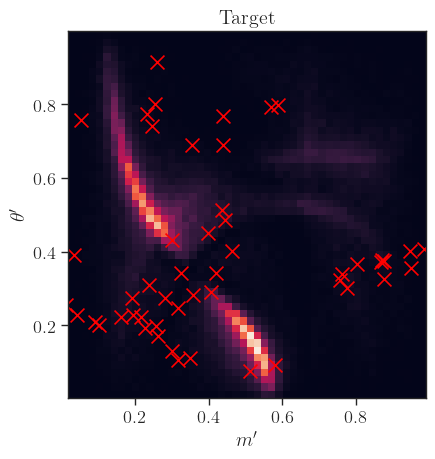

In [13]:
# Visualize 2D Dalitz plot
fig, ax = plt.subplots(1, 1, figsize=(6,5))
n_samples = 100000
h, xedges, yedges, _ = ax.hist2d(mp_thetap[:n_samples,0], mp_thetap[:n_samples,1], 50)

for i in range(K):
    ax.scatter(base.mu[i,0].detach().cpu(), base.mu[i,1].detach().cpu(), s=100, marker='x', color='red')

ax.set_xlabel(r"$m'$")
ax.set_ylabel(r"$\theta'$")
ax.set_title(r'$\mathrm{Target}$')
ax.set_aspect('equal')
fig.tight_layout()
#fig.savefig(r'figs/D-amplitude_SDP_INN_target.pdf', dpi = 300, pad_inches = .1, bbox_inches = 'tight')
#fig.savefig(r'figs/D-amplitude_SDP_INN_target.png', dpi = 300, pad_inches = .1, bbox_inches = 'tight')

In [21]:
# Create samples from trained network
n_samples = 100000
z_gen = base.sample(n_samples)#.cpu().numpy()

(0.0, 1.0)

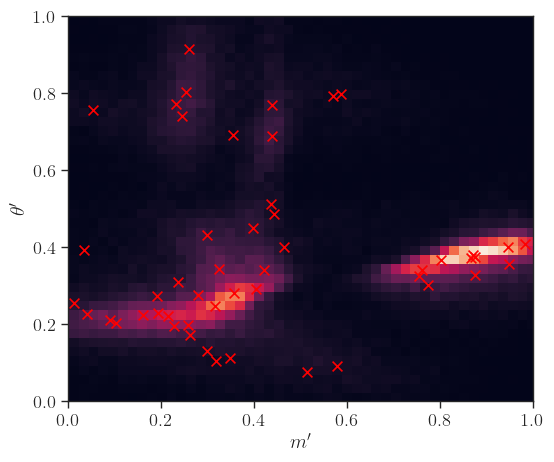

In [22]:
# Plot z_samples on 2d histogram
fig, ax = plt.subplots(1, 1, figsize=(6,5))
h, xedges, yedges, _ = ax.hist2d(z_gen[:,0], z_gen[:,1], 100)
for i in range(K):
    ax.scatter(base.mu[i,0].detach().cpu(), base.mu[i,1].detach().cpu(), s=50, marker='x', color='red')

ax.set_xlabel(r"$m'$")
ax.set_ylabel(r"$\theta'$")

ax.set_xlim(0,1)
ax.set_ylim(0,1)

In [23]:
# Generate m2 samples from latent distribution
mp_thetap_gen, _ = inn(z_gen, rev=True)
mp_thetap_gen = mp_thetap_gen.detach().numpy()[:]

print(mp_thetap_gen.shape)
print(mp_thetap_gen[0])

(100000, 2)
[0.8871185 0.5028615]


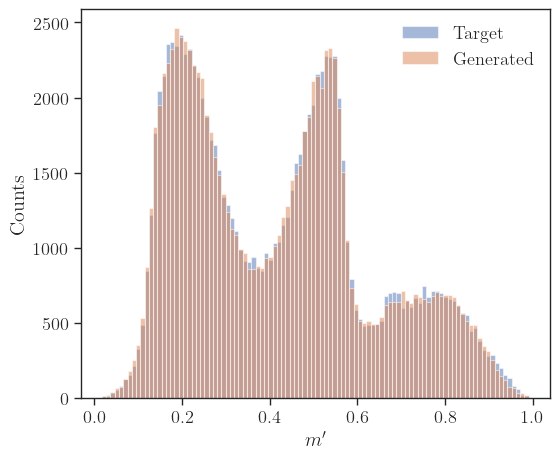

In [24]:
# Visualize 
fig, ax = plt.subplots( figsize=(6,5) )

counts, bins, _ = ax.hist(mp_thetap[:n_samples,0], 100, alpha = 0.5, label = r'$\mathrm{Target}$')
ax.hist(mp_thetap_gen[:,0], bins, alpha=0.5, label = r'$\mathrm{Generated}$')

ax.set_xlabel( r"$m'$")
ax.set_ylabel( r'$\mathrm{Counts}$' )


ax.legend(loc='best', frameon=False)

fig.tight_layout()
#fig.savefig(r'figs/D-amplitude_SDP_mp_INN_target_vs_gen_v2.pdf', dpi = 300, pad_inches = .1, bbox_inches = 'tight')
#fig.savefig(r'figs/D-amplitude_SDP_mp_INN_target_vs_gen_v2.png', dpi = 300, pad_inches = .1, bbox_inches = 'tight')

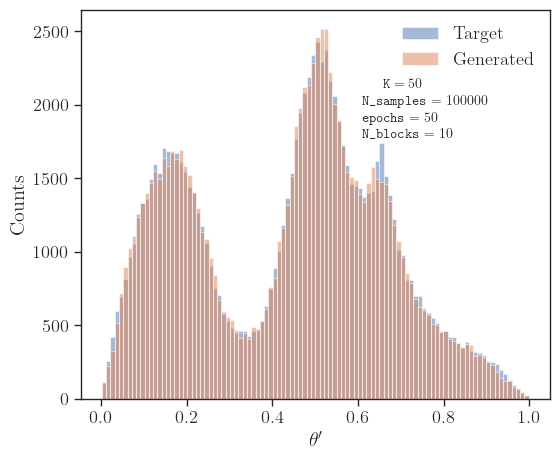

In [25]:
# Visualize 
fig, ax = plt.subplots( figsize=(6,5) )

counts, bins, _ = ax.hist(mp_thetap[:n_samples,1], 100, alpha = 0.5, label = r'$\mathrm{Target}$')
ax.hist(mp_thetap_gen[:,1], bins, alpha=0.5, label = r'$\mathrm{Generated}$')

ax.set_xlabel( r"$\theta'$")
ax.set_ylabel( r'$\mathrm{Counts}$' )

ax.text(0.6, 0.8, rf'$\texttt{{K}} = {K}$ \\ $\texttt{{N\_{{samples}}}} = {n_samples}$ \\ $\texttt{{epochs}} = {epochs}$ \\ $\texttt{{N\_{{blocks}}}} = {n_blocks}$', transform=ax.transAxes, fontsize = 10)

ax.legend(loc='best', frameon=False)

fig.tight_layout()
#fig.savefig(r'figs/D-amplitude_SDP_thetap_INN_target_vs_gen_v2.pdf', dpi = 300, pad_inches = .1, bbox_inches = 'tight')
#fig.savefig(r'figs/D-amplitude_SDP_thetap_INN_target_vs_gen_v2.png', dpi = 300, pad_inches = .1, bbox_inches = 'tight')

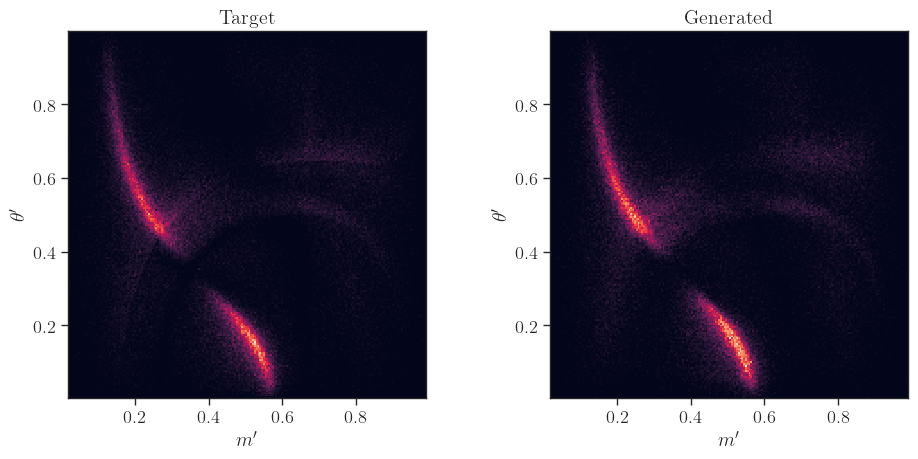

In [26]:
# Visualize 2D Dalitz plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5) )

h_sim, xedges, yedges, _ = ax1.hist2d(mp_thetap[:n_samples,0], mp_thetap[:n_samples,1], 200)
h_gen, _, _, _ = ax2.hist2d(mp_thetap_gen[:,0], mp_thetap_gen[:,1], bins = [xedges, yedges])

ax1.set_xlabel(r"$m'$")
ax1.set_ylabel(r"$\theta'$")
ax1.set_title(r'$\mathrm{Target}$')
ax1.set_aspect('equal')

ax2.set_xlabel(r"$m'$")
ax2.set_ylabel(r"$\theta'$")
ax2.set_title(r'$\mathrm{Generated}$')
ax2.set_aspect('equal')

fig.subplots_adjust(wspace=0, hspace=0)
fig.tight_layout()
#fig.savefig(r'figs/D-amplitude_SDP_INN_target.pdf', dpi = 300, pad_inches = .1, bbox_inches = 'tight')
#fig.savefig(r'figs/D-amplitude_SDP_INN_target.png', dpi = 300, pad_inches = .1, bbox_inches = 'tight')

/tmp/ipykernel_4231/795854995.py:3: RuntimeWarning: invalid value encountered in divide
  h_diff = ax.imshow(np.abs(h_sim - h_gen)/np.abs(h_sim + h_gen), origin='lower', extent=[0,1,0,1], aspect='auto')


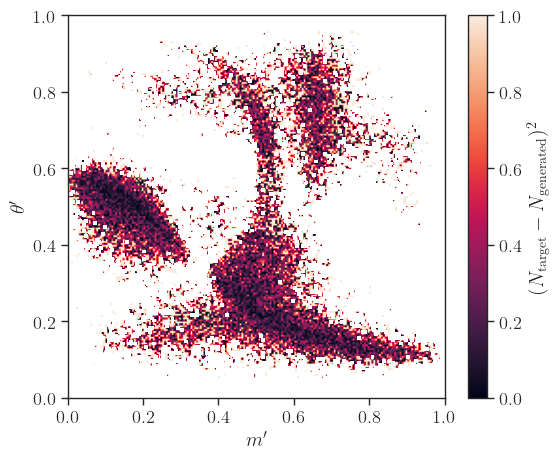

In [20]:
# Plot the squared difference
fig, ax = plt.subplots(1,1,figsize = (6,5))
h_diff = ax.imshow(np.abs(h_sim - h_gen)/np.abs(h_sim + h_gen), origin='lower', extent=[0,1,0,1], aspect='auto')
cbar = fig.colorbar(h_diff, ax=ax)
cbar.set_label(r'$(N_{\mathrm{target}} - N_{\mathrm{generated}})^2$')
ax.set_xlabel(r"$m'$")
ax.set_ylabel(r"$\theta'$")
fig.tight_layout()